## Librerias

In [ ]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

## Dataset

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## Dimensiones

In [ ]:
print('Train: ', x_train.shape)
print('Test: ', x_test.shape)

Train:  (60000, 28, 28)
Test:  (10000, 28, 28)


In [ ]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)

Train:  (60000,)
Test:  (10000,)


In [ ]:
unique_values = np.unique(y_train)
unique_values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Nulos

In [ ]:
# Train
# hay algún valor nulo en x_train
has_nulls = np.isnan(x_train).any()

# contar el número total de valores nulos:
num_nulls = np.isnan(x_train).sum()

print(has_nulls)
print(num_nulls)

False
0


In [ ]:
# Train
#  hay algún valor nulo en y_train
has_nulls = np.isnan(y_train).any()

# contar el número total de valores nulos:
num_nulls = np.isnan(y_train).sum()

print(has_nulls)
print(num_nulls)

False
0


In [ ]:
# Test
#  hay algún valor nulo en y_test
has_nulls = np.isnan(y_test).any()

# contar el número total de valores nulos:
num_nulls = np.isnan(y_test).sum()

print(has_nulls)
print(num_nulls)

False
0


In [ ]:
#  hay algún valor nulo en x_test
has_nulls = np.isnan(x_test).any()

# contar el número total de valores nulos:
num_nulls = np.isnan(x_test).sum()

print(has_nulls)
print(num_nulls)

False
0


## Prendas de vestir

In [ ]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

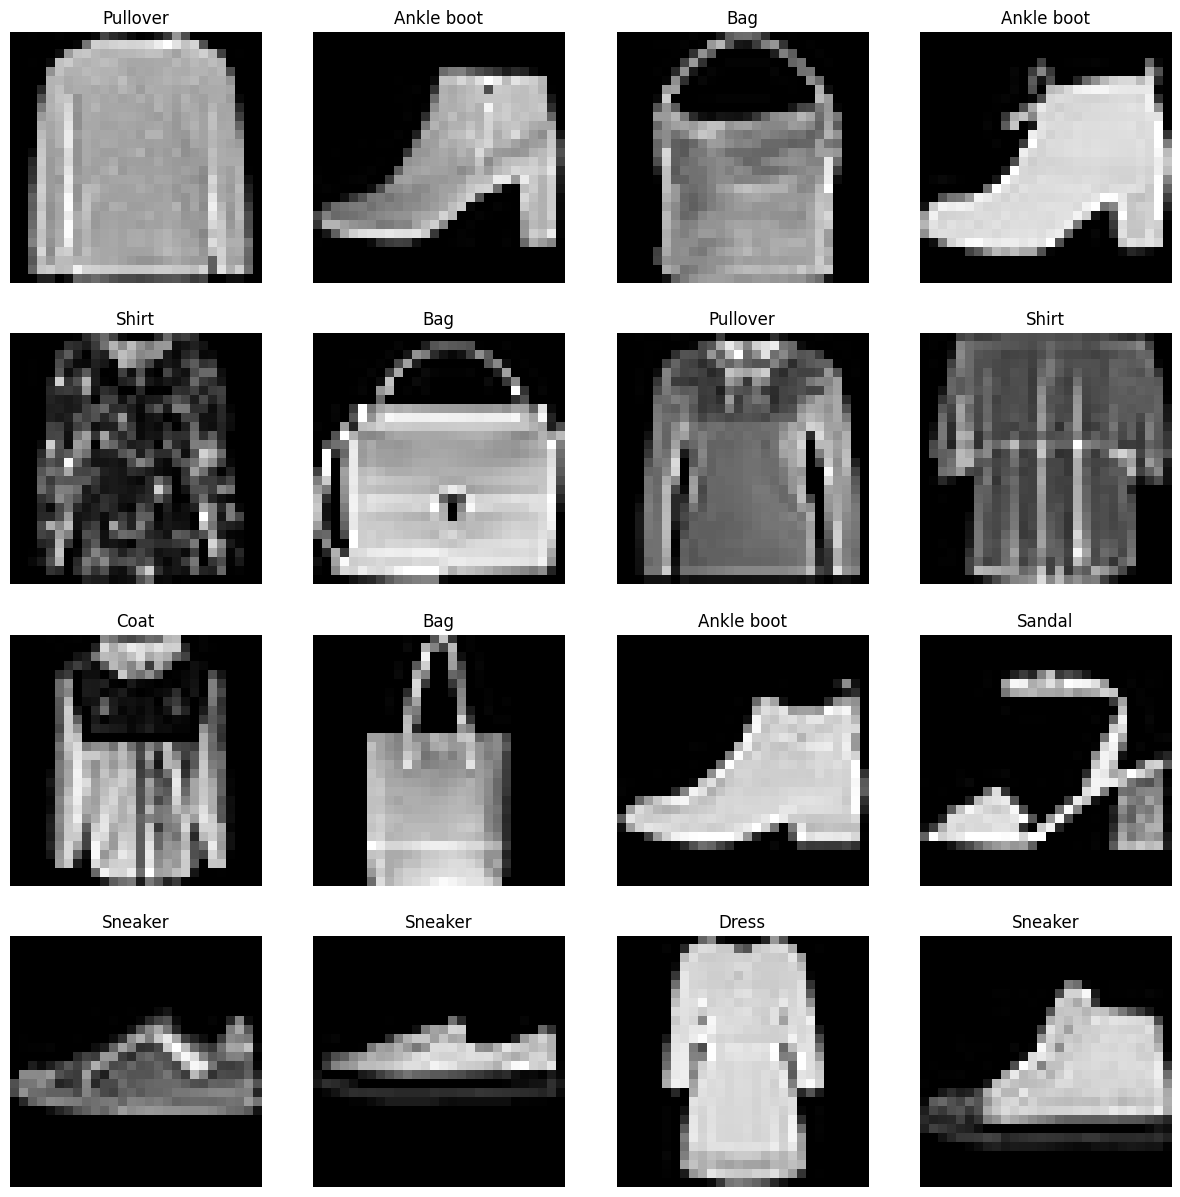

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for row in axes:
    for axe in row:
        index = np.random.randint(x_train.shape[0])  # Usamos x_train.shape[0] en lugar de 60000 para generalidad.
        img = x_train[index]
        label = y_train[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[label])
        axe.set_axis_off()

plt.show()


## Dataset balanceado


In [ ]:
combined_labels = np.concatenate([y_train, y_test])
label_counts = np.bincount(combined_labels)

for label, count in enumerate(label_counts):
    print(f"{label}: {count}")

0: 7000
1: 7000
2: 7000
3: 7000
4: 7000
5: 7000
6: 7000
7: 7000
8: 7000
9: 7000


##  Reshape


In [ ]:
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

## Escalamiento

In [ ]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

## One Hot Encoding


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


## RBF

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='he_uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

## ConvNet-RBF

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import Activation


model = Sequential()

# Convolutional and Pooling Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Flattening Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.15))

#  RBF Layer
model.add(RBFLayer(10, 0.05))
model.add(Activation('softmax'))  # Softmax Layer for Classification


Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                346176    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 rbf_layer_1 (RBFLayer)      (None, 10)                640       
                                                      

Compilar


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)


In [ ]:
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001
    decay_factor = 0.9
    return initial_lr * (decay_factor ** epoch)

reduce_lr = LearningRateScheduler(lr_schedule)

## Entrenamiento

In [ ]:
model.fit(x_train, y_train, epochs=30, callbacks=[reduce_lr])


Epoch 1/30
1875/1875 [==============================] - 36s 19ms/step - loss: 1.9402 - accuracy: 0.8419 - lr: 0.0010
Epoch 2/30
1875/1875 [==============================] - 34s 18ms/step - loss: 1.8044 - accuracy: 0.8878 - lr: 9.0000e-04
Epoch 3/30
1875/1875 [==============================] - 34s 18ms/step - loss: 1.7905 - accuracy: 0.8972 - lr: 8.1000e-04
Epoch 4/30
1875/1875 [==============================] - 34s 18ms/step - loss: 1.7814 - accuracy: 0.9030 - lr: 7.2900e-04
Epoch 5/30
1875/1875 [==============================] - 33s 18ms/step - loss: 1.7755 - accuracy: 0.9057 - lr: 6.5610e-04
Epoch 6/30
1875/1875 [==============================] - 35s 18ms/step - loss: 1.7696 - accuracy: 0.9089 - lr: 5.9049e-04
Epoch 7/30
1875/1875 [==============================] - 35s 19ms/step - loss: 1.7651 - accuracy: 0.9100 - lr: 5.3144e-04
Epoch 8/30
1875/1875 [==============================] - 33s 18ms/step - loss: 1.7601 - accuracy: 0.9120 - lr: 4.7830e-04
Epoch 9/30
1875/1875 [==============

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6511 - accuracy: 0.9120


[1.6510857343673706, 0.9120000004768372]

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/30
1875/1875 [==============================] - 38s 20ms/step - loss: 1.9552 - accuracy: 0.8379 - val_loss: 1.7468 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 2/30
1875/1875 [==============================] - 37s 20ms/step - loss: 1.8104 - accuracy: 0.8837 - val_loss: 1.6987 - val_accuracy: 0.8839 - lr: 9.0000e-04
Epoch 3/30
1875/1875 [==============================] - 36s 19ms/step - loss: 1.7954 - accuracy: 0.8928 - val_loss: 1.6869 - val_accuracy: 0.8878 - lr: 8.1000e-04
Epoch 4/30
1875/1875 [==============================] - 36s 19ms/step - loss: 1.7862 - accuracy: 0.8974 - val_loss: 1.6804 - val_accuracy: 0.8913 - lr: 7.2900e-04
Epoch 5/30
1875/1875 [==============================] - 36s 19ms/step - loss: 1.7812 - accuracy: 0.9012 - val_loss: 1.6767 - val_accuracy: 0.8940 - lr: 6.5610e-04
Epoch 6/30
1875/1875 [==============================] - 36s 19ms/step - loss: 1.7740 - accuracy: 0.9038 - val_loss: 1.6713 - val_accuracy: 0.8959 - lr: 5.9049e-04
Epoch 7/30
1875/1875 [====

## Evaluación

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.6533 - accuracy: 0.9084


[1.6532775163650513, 0.9083999991416931]

## Gráfico de pérdida y precisión

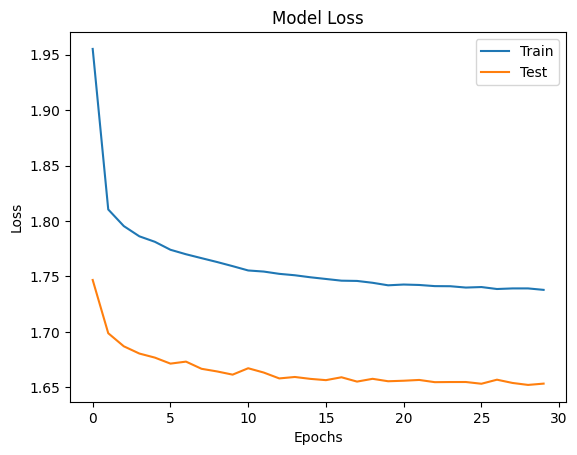

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

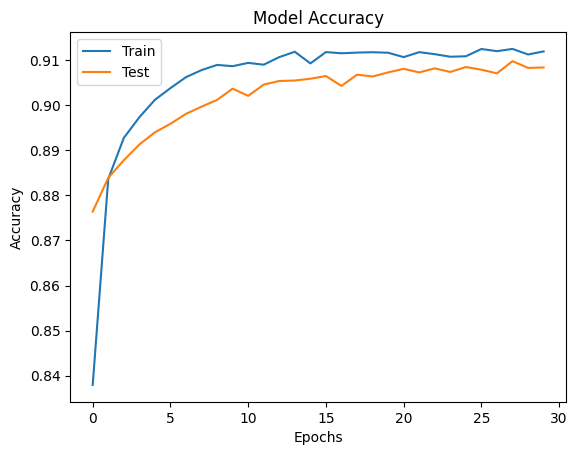

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

## Matriz de confusión

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import numpy as np

313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.86      0.86      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.84      0.87      0.85      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.85      0.86      0.86      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.74      0.72      0.73      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



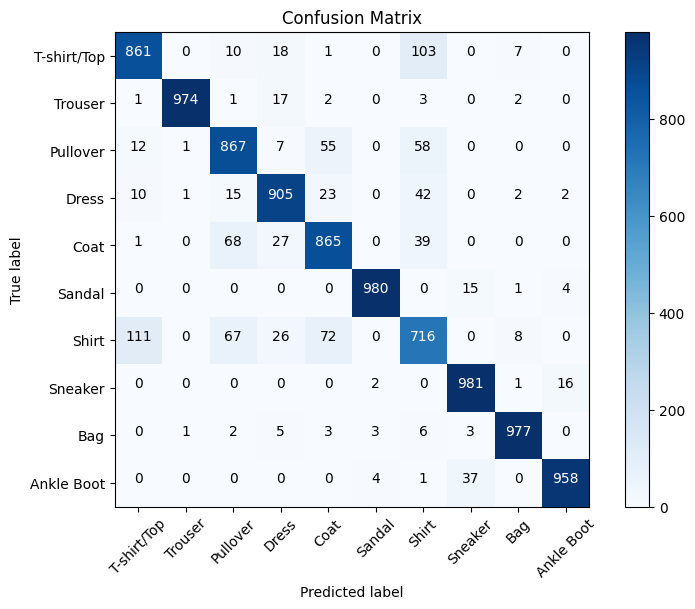

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

report = classification_report(Y_true, Y_pred_classes, target_names=['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])
print(report)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, classes=['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])
plt.show()


## Predicciones

In [ ]:
incorrect = []
for i in range(len(y_test)):
    if(not Y_pred_classes[i] == Y_true[i]):
        incorrect.append(i)
    if(len(incorrect) == 4):
        break

In [ ]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

Text(0.5, 1.0, 'Predicted Label : Sandal\nActual Label : Ankle boot')

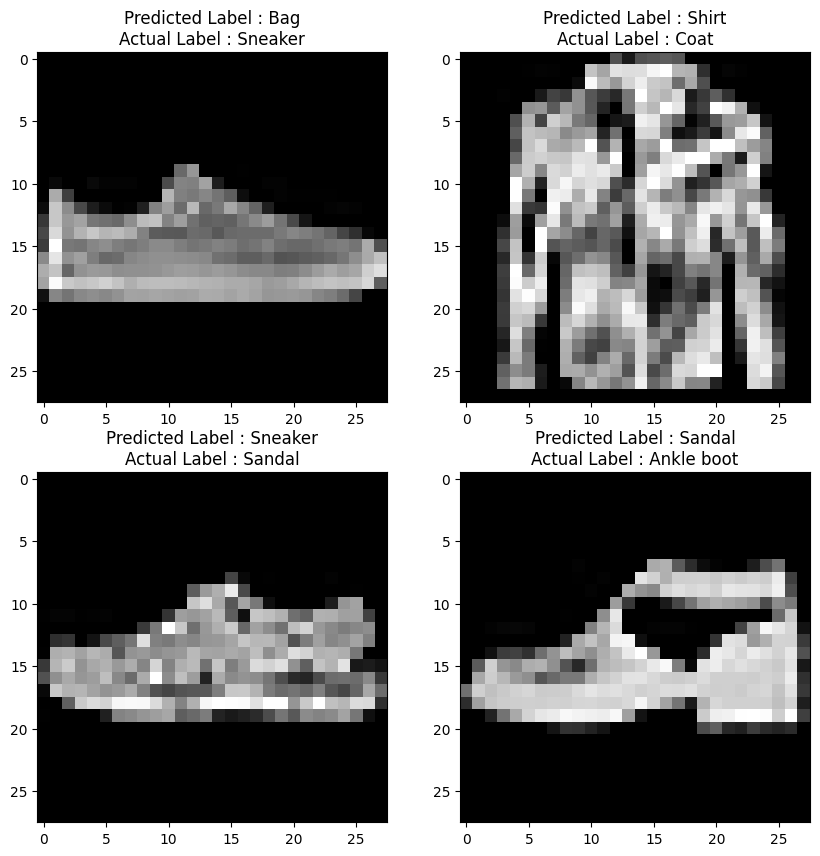

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[incorrect[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " +
                 str(clothing[Y_true[incorrect[0]]]))
ax[0,1].imshow(x_test[incorrect[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " +
                 str(clothing[Y_true[incorrect[1]]]))
ax[1,0].imshow(x_test[incorrect[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " +
                 str(clothing[Y_true[incorrect[2]]]))
ax[1,1].imshow(x_test[incorrect[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " +
                 str(clothing[Y_true[incorrect[3]]]))